In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1', usecols=['v1', 'v2'])
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

In [3]:
# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
  target                                            message
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
# Add a column for message length in words
df['message_ln'] = df['message'].apply(lambda x: len(x.split(' ')))
print("\nDataset with message lengths:")
print(df.head())

# Maximum message length
max_length = max(df['message_ln'])
print(f"\nMaximum message length (in words): {max_length}")


Dataset with message lengths:
  target                                            message  message_ln
0    ham  Go until jurong point, crazy.. Available only ...          20
1    ham                      Ok lar... Joking wif u oni...           6
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...          28
3    ham  U dun say so early hor... U c already then say...          11
4    ham  Nah I don't think he goes to usf, he lives aro...          13

Maximum message length (in words): 171


In [5]:
# Exploratory Data Analysis (EDA)

In [6]:
pd.set_option('display.max_columns', 500)
print("\nDataset Information:")
print(df.info())

print("\nDataset Shape:", df.shape)
print("Number of Duplicated Rows:", df.duplicated().sum())
print("Number of Missing Values:\n", df.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   target      5572 non-null   object
 1   message     5572 non-null   object
 2   message_ln  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB
None

Dataset Shape: (5572, 3)
Number of Duplicated Rows: 403
Number of Missing Values:
 target        0
message       0
message_ln    0
dtype: int64


In [7]:
# Check Imbalance ? 

balance_counts = df.groupby('target')['target'].agg('count').values
print("\nBalance Counts:", balance_counts)


Balance Counts: [4825  747]


In [8]:
# Calculate counts and percentages of each class
label_counts = df['target'].value_counts()
ham_count = label_counts['ham']
spam_count = label_counts['spam']
total_messages = ham_count + spam_count
ham_percentage = (ham_count / total_messages) * 100
spam_percentage = (spam_count / total_messages) * 100

print(f"\nHam messages: {ham_count} ({ham_percentage:.2f}%)")
print(f"Spam messages: {spam_count} ({spam_percentage:.2f}%)")

# Define colors for visualization
color_ham = '#1f77b4'   # Blue for 'ham'
color_spam = '#ff7f0e'  # Orange for 'spam'



Ham messages: 4825 (86.59%)
Spam messages: 747 (13.41%)


In [9]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Ham'],
    y=[ham_count],
    name='Ham',
    text=[f'{ham_count} messages<br>{ham_percentage:.2f}%'],
    textposition='auto',
    marker_color=color_ham
))

fig.add_trace(go.Bar(
    x=['Spam'],
    y=[spam_count],
    name='Spam',
    text=[f'{spam_count} messages<br>{spam_percentage:.2f}%'],
    textposition='auto',
    marker_color=color_spam
))

# Update the layout of the bar chart
fig.update_layout(
    title={
        'text': 'Dataset Distribution by Target',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24, 'family': 'Times New Roman'}
    },
    xaxis_title='Message Type',
    yaxis_title='Number of Messages',
    bargap=0.5,
    showlegend=False,
    template='simple_white'
)

fig.show()

In [10]:
# Create a pie chart for class distribution
labels = ['Ham', 'Spam']
counts = [ham_count, spam_count]

fig_pie = px.pie(
    names=labels,
    values=counts,
    color=labels,
    color_discrete_map={'Ham': color_ham, 'Spam': color_spam},
    title='Proportion of Ham vs. Spam Messages',
    hole=0.4  # Creates a donut chart
)

# Update layout of the pie chart
fig_pie.update_traces(
    textposition='inside',
    textinfo='percent+label'
)

fig_pie.update_layout(
    title={
        'text': 'Proportion of Ham vs. Spam Messages',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24, 'family': 'Times New Roman'}
    },
    showlegend=False
)

fig_pie.show()

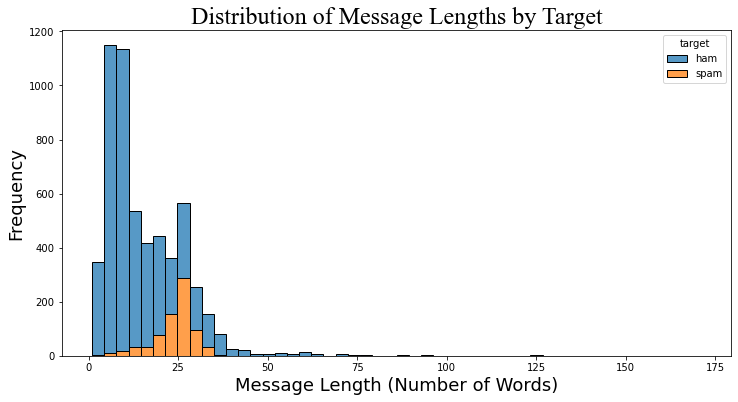

In [11]:
# Plot the distribution of message lengths by target
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='message_ln', hue='target', multiple='stack', bins=50, palette=[color_ham, color_spam])
plt.title('Distribution of Message Lengths by Target', fontsize=24, fontfamily='Times New Roman')
plt.xlabel('Message Length (Number of Words)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()


In [12]:
# Encoding, target labels: 'spam' as 1 and 'ham' as 0
df['target'] = df['target'].map({'spam': 1, 'ham': 0})
print("\nEncoded Target Labels:")
print(df.head())


Encoded Target Labels:
   target                                            message  message_ln
0       0  Go until jurong point, crazy.. Available only ...          20
1       0                      Ok lar... Joking wif u oni...           6
2       1  Free entry in 2 a wkly comp to win FA Cup fina...          28
3       0  U dun say so early hor... U c already then say...          11
4       0  Nah I don't think he goes to usf, he lives aro...          13


In [13]:
# Drop duplicate messages
df.drop_duplicates(keep='first', inplace=True)
print("\nDataset Shape after Dropping Duplicates:", df.shape)


Dataset Shape after Dropping Duplicates: (5169, 3)


In [14]:
# Verify the class distribution after encoding
print("\nClass Distribution After Encoding:")
print(df['target'].value_counts())


Class Distribution After Encoding:
0    4516
1     653
Name: target, dtype: int64


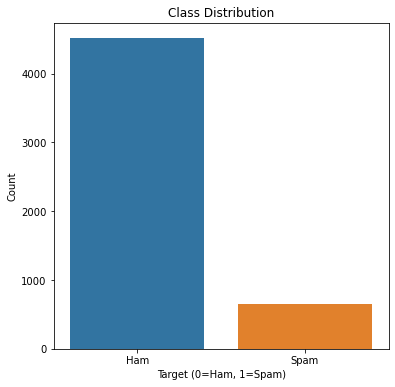

In [15]:
# Visualize the original class distribution
plt.figure(figsize=(6,6))
sns.countplot(x='target', data=df, palette=[color_ham, color_spam])
plt.title('Class Distribution')
plt.xlabel('Target (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'])
plt.show()

In [16]:
# Calculate number of characters and words in each message
df['num_chars'] = df['message'].str.len()
df['num_words'] = df['message'].str.split().apply(len)

In [17]:
# Descriptive statistics
desc_stats = df[['num_chars', 'num_words']].describe().round()
print("\nDescriptive Statistics:")
print(desc_stats)


Descriptive Statistics:
       num_chars  num_words
count     5169.0     5169.0
mean        79.0       15.0
std         58.0       11.0
min          2.0        1.0
25%         36.0        7.0
50%         60.0       12.0
75%        117.0       22.0
max        910.0      171.0


In [18]:
# Calculate the correlation matrix
corr_matrix = df[['num_chars', 'num_words', 'target']].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)


Correlation Matrix:
           num_chars  num_words    target
num_chars   1.000000   0.973667  0.384717
num_words   0.973667   1.000000  0.286576
target      0.384717   0.286576  1.000000


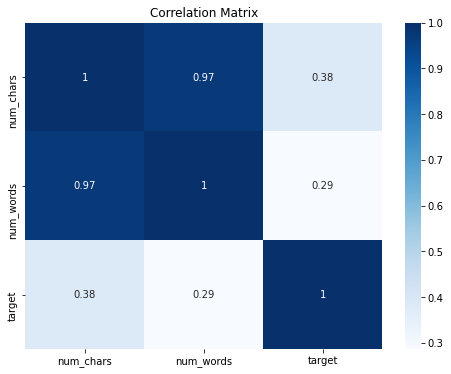

In [19]:
# Plot the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

In [20]:
# Map target labels for better readability in plots
df['target_label'] = df['target'].map({0: 'HAM', 1: 'SPAM'})

In [21]:
# Grouped statistics by target label
grouped_stats = df.groupby('target_label')[['num_chars', 'num_words']].agg(['mean', 'min', 'max']).round()
print("\nGrouped Statistics by Class:")
print(grouped_stats)


Grouped Statistics by Class:
             num_chars          num_words         
                  mean min  max      mean min  max
target_label                                      
HAM               70.0   2  910      14.0   1  171
SPAM             138.0  13  224      24.0   2   35


In [22]:
# Calculate average values for plotting
avg_values = df.groupby('target_label')[['num_chars', 'num_words']].mean().reset_index()

In [23]:
avg_melted = avg_values.melt(id_vars='target_label', value_vars=['num_chars', 'num_words'],
                             var_name='Measurement', value_name='Average')

In [24]:
colors_plot = ['blue', 'red']

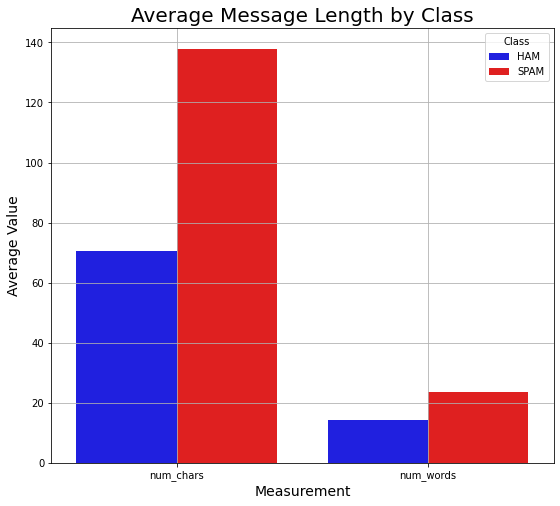

In [25]:
# Plot average message lengths by class
plt.figure(figsize=(9, 8))
sns.barplot(x='Measurement', y='Average', hue='target_label', data=avg_melted, palette=colors_plot)
plt.title('Average Message Length by Class', fontsize=20)
plt.xlabel('Measurement', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.legend(title='Class')
plt.grid(True)
plt.show()

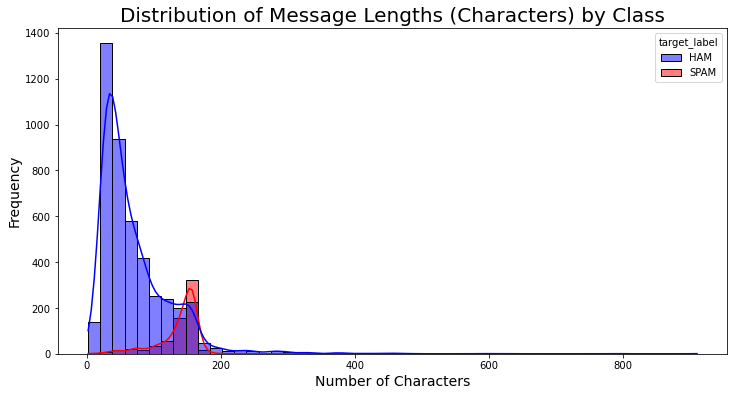

In [26]:
# Histogram of number of characters
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='num_chars', hue='target_label', bins=50, palette=colors_plot, kde=True)
plt.title('Distribution of Message Lengths (Characters) by Class', fontsize=20)
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

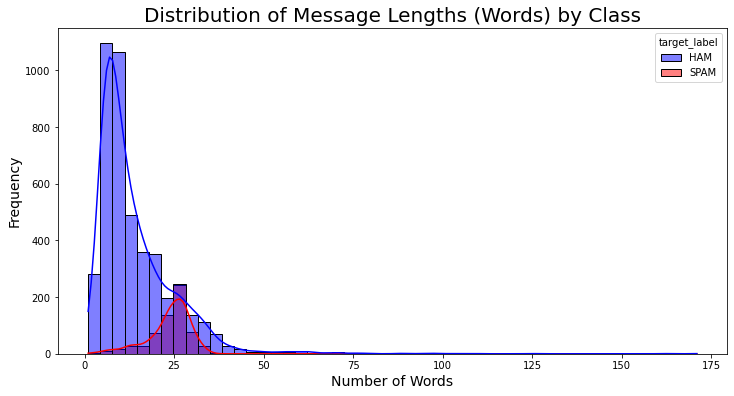

In [27]:
# Histogram of number of words
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='num_words', hue='target_label', bins=50, palette=colors_plot, kde=True)
plt.title('Distribution of Message Lengths (Words) by Class', fontsize=20)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

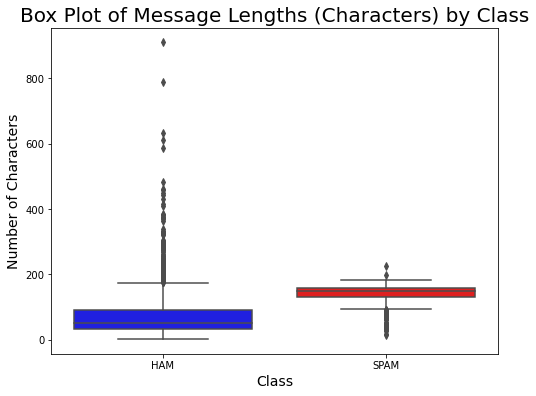

In [28]:
# Box plot of number of characters
plt.figure(figsize=(8, 6))
sns.boxplot(x='target_label', y='num_chars', data=df, palette=colors_plot)
plt.title('Box Plot of Message Lengths (Characters) by Class', fontsize=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Characters', fontsize=14)
plt.show()


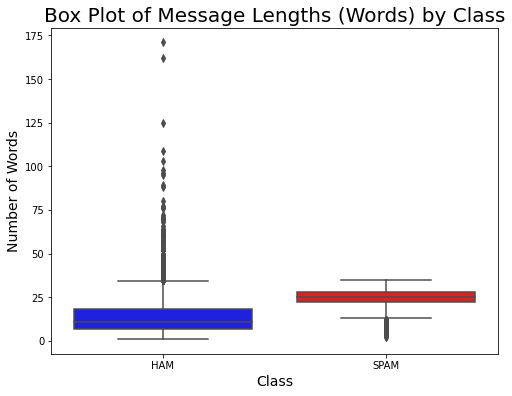

In [29]:
# Box plot of number of words
plt.figure(figsize=(8, 6))
sns.boxplot(x='target_label', y='num_words', data=df, palette=colors_plot)
plt.title('Box Plot of Message Lengths (Words) by Class', fontsize=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Words', fontsize=14)
plt.show()


In [30]:
'''
Observations and Insights

1. **Class Imbalance:**
   - The dataset is imbalanced with a majority of 'ham' messages and a minority of 'spam' messages.
   - This is evident from both the count plots and percentage calculations.

2. **Message Lengths:**
   - **Spam Messages:** Tend to have a higher average number of characters and words compared to ham messages.
   - **Ham Messages:** Generally shorter in length, both in characters and words.

3. **Distribution Patterns:**
   - **Histograms:** Spam messages exhibit a wider distribution towards higher message lengths, indicating more variability.
   - **Ham messages:** More concentrated around shorter lengths, suggesting consistency in their brevity.

4. **Correlation:**
   - There's a positive correlation between `num_chars` and `num_words`, which is expected as longer messages naturally have more words.
   - A slight positive correlation between message length (`num_chars` and `num_words`) and the target label suggests that longer messages may be more likely to be spam.

5. **Box Plots:**
   - **Spam:** Shows greater variability in message lengths with potential outliers.
   - **Ham:** More consistent and shorter message lengths with fewer outliers.

6. **Implications for Modeling:**
   - Message length features (`num_chars`, `num_words`) could be valuable predictors in distinguishing between spam and ham messages.
   - Given the class imbalance, appropriate strategies (like class weighting or resampling techniques) should be considered during model training to ensure the model doesn't become biased towards the majority class.

'''

"\nObservations and Insights\n\n1. **Class Imbalance:**\n   - The dataset is imbalanced with a majority of 'ham' messages and a minority of 'spam' messages.\n   - This is evident from both the count plots and percentage calculations.\n\n2. **Message Lengths:**\n   - **Spam Messages:** Tend to have a higher average number of characters and words compared to ham messages.\n   - **Ham Messages:** Generally shorter in length, both in characters and words.\n\n3. **Distribution Patterns:**\n   - **Histograms:** Spam messages exhibit a wider distribution towards higher message lengths, indicating more variability.\n   - **Ham messages:** More concentrated around shorter lengths, suggesting consistency in their brevity.\n\n4. **Correlation:**\n   - There's a positive correlation between `num_chars` and `num_words`, which is expected as longer messages naturally have more words.\n   - A slight positive correlation between message length (`num_chars` and `num_words`) and the target label suggest

In [31]:
from sklearn.linear_model import LogisticRegression

# Define the classifier with class weights
clf = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Prepare data for training
X = df['message']
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the model
clf.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_vec)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[900   3]
 [ 16 115]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.97      0.88      0.92       131

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train_vec, y_train, cv=skf, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Mean F1 Score: {scores.mean():.2f}")


Cross-Validation F1 Scores: [0.90816327 0.94472362 0.94059406 0.90909091 0.90452261]
Mean F1 Score: 0.92


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[893  10]
 [ 15 116]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       903
           1       0.92      0.89      0.90       131

    accuracy                           0.98      1034
   macro avg       0.95      0.94      0.94      1034
weighted avg       0.98      0.98      0.98      1034



In [34]:
# Preprocessing and Corpus cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words += more_stopwords

def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

stemmer = nltk.SnowballStemmer("english")

def stem_text(text):
    return ' '.join(stemmer.stem(word) for word in text.split())

def preprocess_data(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text

In [35]:
# Apply preprocessing to the messages
print("\nApplying preprocessing to messages...")
df['cleaned_message'] = df['message'].apply(preprocess_data)
print("Preprocessing completed.")

# Display the first few cleaned messages
print("\nFirst 5 cleaned messages:")
print(df[['message', 'cleaned_message']].head())



Applying preprocessing to messages...
Preprocessing completed.

First 5 cleaned messages:
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazi avail bugi n great world...  
1                                ok lar joke wif oni  
2  free entri wkli comp win fa cup final tkts may...  
3                      dun say earli hor alreadi say  
4          nah dont think goe usf live around though  


In [36]:
# Numeric,, Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_message'])


In [37]:
# Combine TF-IDF features with additional numerical features
import scipy
from scipy.sparse import hstack

# Selecting numerical features
numerical_features = df[['num_chars', 'num_words']].values

X = hstack([X_tfidf, scipy.sparse.csr_matrix(numerical_features)])

In [38]:
y = df['target'].values

In [39]:
# Data distribution with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Training set size: (4135, 32317)
Testing set size: (1034, 32317)


In [40]:
# Handle Class Imbalance using class weights
from sklearn.utils import class_weight
classes = np.unique(y_train)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("\nClass Weights:", class_weights)



Class Weights: {0: 0.5722391364517022, 1: 3.960727969348659}


In [41]:
from sklearn.metrics import roc_auc_score, average_precision_score

def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Train the model and evaluate its performance.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = None
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = y_pred  # Fallback
    
    print(f"\n--- {model_name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_pred_proba is not None and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        print(f"ROC AUC Score: {roc_auc:.2f}")
        print(f"Precision-Recall AUC Score: {pr_auc:.2f}")
    
    return y_pred, y_pred_proba


In [42]:
# Based on either TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer or Count Vectorizer
from sklearn.metrics import roc_auc_score, average_precision_score


In [43]:
# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_pred, lr_proba = train_evaluate_model(lr_model, X_train, y_train, X_test, y_test, model_name="Logistic Regression")



--- Logistic Regression ---
Confusion Matrix:
[[865  38]
 [ 18 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       903
           1       0.75      0.86      0.80       131

    accuracy                           0.95      1034
   macro avg       0.86      0.91      0.89      1034
weighted avg       0.95      0.95      0.95      1034

ROC AUC Score: 0.98
Precision-Recall AUC Score: 0.83


In [44]:
# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_pred, nb_proba = train_evaluate_model(nb_model, X_train, y_train, X_test, y_test, model_name="Multinomial Naive Bayes")
'''
Comments : so weird, that maybe due to naive independence assumptions by naive bayes in midst of an imbalanced dataset also Custom bow + TF-IDF transformer gonna improve! 
'''


--- Multinomial Naive Bayes ---
Confusion Matrix:
[[903   0]
 [131   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       903
           1       0.00      0.00      0.00       131

    accuracy                           0.87      1034
   macro avg       0.44      0.50      0.47      1034
weighted avg       0.76      0.87      0.81      1034

ROC AUC Score: 0.19
Precision-Recall AUC Score: 0.08


'\nComments : so weird, that maybe due to naive independence assumptions by naive bayes in midst of an imbalanced dataset also Custom bow + TF-IDF transformer gonna improve! \n'

In [45]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_pred, rf_proba = train_evaluate_model(rf_model, X_train, y_train, X_test, y_test, model_name="Random Forest Classifier")



--- Random Forest Classifier ---
Confusion Matrix:
[[903   0]
 [ 30 101]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       903
           1       1.00      0.77      0.87       131

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034

ROC AUC Score: 0.99
Precision-Recall AUC Score: 0.97


In [46]:
# Gradient Boosting Classifier (e.g., XGBoost)
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)
xgb_pred, xgb_proba = train_evaluate_model(xgb_model, X_train, y_train, X_test, y_test, model_name="XGBoost Classifier")



--- XGBoost Classifier ---
Confusion Matrix:
[[886  17]
 [ 17 114]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       903
           1       0.87      0.87      0.87       131

    accuracy                           0.97      1034
   macro avg       0.93      0.93      0.93      1034
weighted avg       0.97      0.97      0.97      1034

ROC AUC Score: 0.98
Precision-Recall AUC Score: 0.95


In [47]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def cross_validate_model(model, X, y, model_name="Model", cv=5):
    """
    Perform cross-validation and print average F1 scores.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    print(f"\n{model_name} Cross-Validation F1 Scores: {scores}")
    print(f"Mean F1 Score: {scores.mean():.2f}")


In [48]:
cross_validate_model(lr_model, X_tfidf, y, model_name="Logistic Regression")


Logistic Regression Cross-Validation F1 Scores: [0.89068826 0.92063492 0.88333333 0.87096774 0.90118577]
Mean F1 Score: 0.89


In [49]:
cross_validate_model(rf_model, X_tfidf, y, model_name="Random Forest Classifier")


Random Forest Classifier Cross-Validation F1 Scores: [0.82352941 0.83035714 0.8        0.86580087 0.83408072]
Mean F1 Score: 0.83


In [50]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

target                                            message  message_ln  \
0       0  Go until jurong point, crazy.. Available only ...          20   
1       0                      Ok lar... Joking wif u oni...           6   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...          28   
3       0  U dun say so early hor... U c already then say...          11   
4       0  Nah I don't think he goes to usf, he lives aro...          13   

   num_chars  num_words target_label  \
0        111         20          HAM   
1         29          6          HAM   
2        155         28         SPAM   
3         49         11          HAM   
4         61         13          HAM   

                                     cleaned_message  \
0  go jurong point crazi avail bugi n great world...   
1                                ok lar joke wif oni   
2  free entri wkli comp win fa cup final tkts may...   
3                      dun say earli hor alreadi say   
4          nah dont think goe usf live around though   

                                       message_clean  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in  a wkly comp to win fa cup final...  
3        u dun say so early hor u c already then say  
4  nah i dont think he goes to usf he lives aroun...

In [51]:
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

target                                            message  message_ln  \
0       0  Go until jurong point, crazy.. Available only ...          20   
1       0                      Ok lar... Joking wif u oni...           6   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...          28   
3       0  U dun say so early hor... U c already then say...          11   
4       0  Nah I don't think he goes to usf, he lives aro...          13   

   num_chars  num_words target_label  \
0        111         20          HAM   
1         29          6          HAM   
2        155         28         SPAM   
3         49         11          HAM   
4         61         13          HAM   

                                     cleaned_message  \
0  go jurong point crazi avail bugi n great world...   
1                                ok lar joke wif oni   
2  free entri wkli comp win fa cup final tkts may...   
3                      dun say earli hor alreadi say   
4          nah dont think goe usf live around though   

                                       message_clean  
0  go jurong point crazy available bugis n great ...  
1                              ok lar joking wif oni  
2  free entry wkly comp win fa cup final tkts may...  
3                      dun say early hor already say  
4        nah dont think goes usf lives around though

In [52]:
df['message_clean'] = df['message_clean'].apply(stem_text)
df.head()

target                                            message  message_ln  \
0       0  Go until jurong point, crazy.. Available only ...          20   
1       0                      Ok lar... Joking wif u oni...           6   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...          28   
3       0  U dun say so early hor... U c already then say...          11   
4       0  Nah I don't think he goes to usf, he lives aro...          13   

   num_chars  num_words target_label  \
0        111         20          HAM   
1         29          6          HAM   
2        155         28         SPAM   
3         49         11          HAM   
4         61         13          HAM   

                                     cleaned_message  \
0  go jurong point crazi avail bugi n great world...   
1                                ok lar joke wif oni   
2  free entri wkli comp win fa cup final tkts may...   
3                      dun say earli hor alreadi say   
4          nah dont think goe usf live around though   

                                       message_clean  
0  go jurong point crazi avail bugi n great world...  
1                                ok lar joke wif oni  
2  free entri wkli comp win fa cup final tkts may...  
3                      dun say earli hor alreadi say  
4          nah dont think goe usf live around though

In [53]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

target                                            message  message_ln  \
0       0  Go until jurong point, crazy.. Available only ...          20   
1       0                      Ok lar... Joking wif u oni...           6   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...          28   
3       0  U dun say so early hor... U c already then say...          11   
4       0  Nah I don't think he goes to usf, he lives aro...          13   

   num_chars  num_words target_label  \
0        111         20          HAM   
1         29          6          HAM   
2        155         28         SPAM   
3         49         11          HAM   
4         61         13          HAM   

                                     cleaned_message  \
0  go jurong point crazi avail bugi n great world...   
1                                ok lar joke wif oni   
2  free entri wkli comp win fa cup final tkts may...   
3                      dun say earli hor alreadi say   
4          nah dont think goe usf live around though   

                                       message_clean  
0  go jurong point crazi avail bugi n great world...  
1                                ok lar joke wif oni  
2  free entri wkli comp win fa cup final tkts may...  
3                        dun say ear hor alreadi say  
4          nah dont think goe usf live around though

In [54]:
# Tokens Visualisation

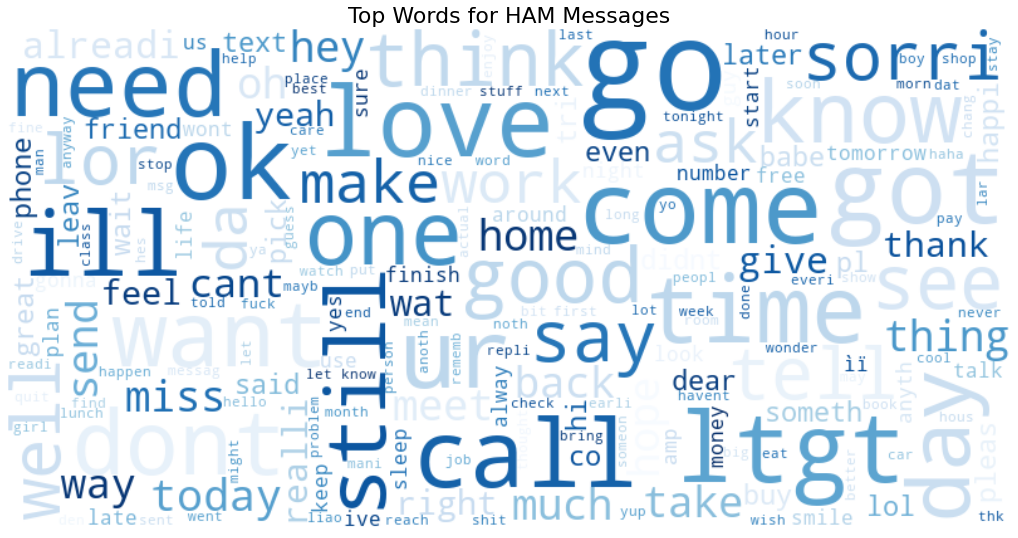

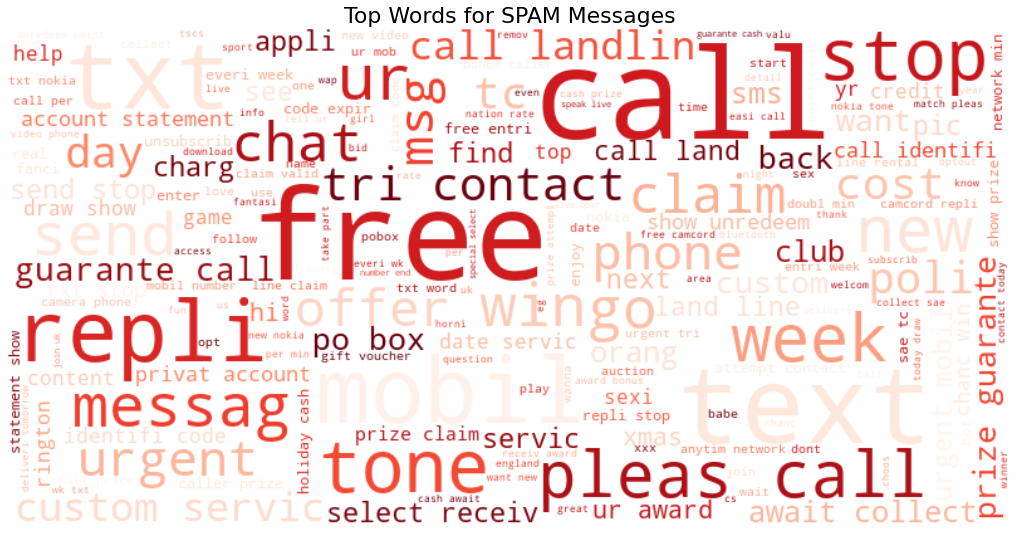

In [55]:
# Word clouds Generation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

if 'cleaned_message' not in df.columns:
    raise ValueError("The column 'cleaned_message' does not exist in the DataFrame.")

if 'target' not in df.columns:
    raise ValueError("The column 'target' does not exist in the DataFrame.")

if 'target_label' not in df.columns:
    df['target_label'] = df['target'].map({0: 'HAM', 1: 'SPAM'})

# Word cloud for 'HAM' messages
ham_text = ' '.join(df[df['target_label'] == 'HAM']['cleaned_message'])
wc_ham = WordCloud(
    background_color='white',
    max_words=200,
    colormap='Blues',
    width=800,
    height=400,
    max_font_size=100,
    random_state=42
).generate(ham_text)

plt.figure(figsize=(18,10))
plt.title('Top Words for HAM Messages', fontdict={'size': 22})
plt.imshow(wc_ham, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word cloud for 'SPAM' messages
spam_text = ' '.join(df[df['target_label'] == 'SPAM']['cleaned_message'])
wc_spam = WordCloud(
    background_color='white',
    max_words=200,
    colormap='Reds',
    width=800,
    height=400,
    max_font_size=100,
    random_state=42
).generate(spam_text)

plt.figure(figsize=(18,10))
plt.title('Top Words for SPAM Messages', fontdict={'size': 22})
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

In [56]:
X = df['cleaned_message']
y = df['target']

In [57]:
print(len(X), len(y))

5169 5169


In [58]:
# First split: 80% train_val and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserves class distribution
)
# Print the sizes of each set
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 4135
Test set size: 1034


In [59]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vect = CountVectorizer()

# Fit the vectorizer on the training data
vect.fit(X_train)

# Transform the training, validation, and test sets into term-frequency matrices
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

# Print the shapes to verify
print(f"Training DTM shape: {X_train_dtm.shape}")
print(f"Test DTM shape: {X_test_dtm.shape}")

Training DTM shape: (4135, 5841)
Test DTM shape: (1034, 5841)


In [60]:
#Based on Gridsearch
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [61]:
# TFIDF

In [62]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<4135x5841 sparse matrix of type '<class 'numpy.float64'>'
	with 31781 stored elements in Compressed Sparse Row format>

In [63]:
# Glove and Word embeddings 

In [64]:
texts = df['message_clean']
target = df['target']

In [65]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6724

In [66]:
'''

WordEmbeddings: Glove

GloVe method is built on an important idea,

    You can derive semantic relationships between words from the co-occurrence matrix.

To obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. 
'''

'\n\nWordEmbeddings: Glove\n\nGloVe method is built on an important idea,\n\n    You can derive semantic relationships between words from the co-occurrence matrix.\n\nTo obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.\n\nWord embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. \n'

In [67]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 2886,  261, ...,    0,    0,    0],
       [   8,  219,  543, ...,    0,    0,    0],
       [  10,  394,  770, ...,    0,    0,    0],
       ...,
       [6722, 1353, 6723, ...,    0,    0,    0],
       [ 134, 1162, 1489, ...,    0,    0,    0],
       [1833,  417,  181, ...,    0,    0,    0]])

In [68]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings with UTF-8 encoding
with open('glove.6B.100d.txt', encoding="utf-8") as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

In [69]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [70]:
import numpy as np
import plotly.figure_factory as ff
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
# Define labels for predicted and actual classes
predicted_labels = ['Ham', 'Spam']
actual_labels = ['Ham', 'Spam']

def plot_confusion_matrix(confusion_matrix_values, 
                          predicted_labels=predicted_labels, 
                          actual_labels=actual_labels,
                          color_scale='Blues'):
    """
    Creates an annotated heatmap for the confusion matrix using Plotly.

    Parameters:
    - confusion_matrix_values (2D array): The confusion matrix values.
    - predicted_labels (list): Labels for the predicted classes.
    - actual_labels (list): Labels for the actual classes.
    - color_scale (str): Color scale for the heatmap.

    Returns:
    - fig: A Plotly figure object representing the confusion matrix.
    """
    
    # Flip the confusion matrix vertically for correct alignment
    flipped_matrix = np.flip(confusion_matrix_values, 0)
    
    # Convert each element to string for annotations
    annotation_text = [[str(value) for value in row] for row in flipped_matrix]
    
    # Create the annotated heatmap
    fig = ff.create_annotated_heatmap(
        flipped_matrix, 
        x=predicted_labels, 
        y=actual_labels, 
        annotation_text=annotation_text, 
        colorscale=color_scale,
        showscale=True
    )
    
    # Update layout for better aesthetics
    fig.update_layout(
        title='<b>Confusion Matrix</b>',
        xaxis=dict(title='Predicted Label'),
        yaxis=dict(title='Actual Label'),
        yaxis_autorange='reversed'  
    )
    
    return fig

In [71]:
# Modelling after custom CountVectorizer and Tfidf transformer

In [72]:
from sklearn.utils import class_weight
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Initialize the vectorizer and TF-IDF transformer
vect = CountVectorizer()  
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_dtm)
X_test_tfidf = tfidf_transformer.transform(X_test_dtm)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',  # Balanced strategy to handle class imbalance
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary for easier access
class_weights_dict = {i: class_weights[i] for i in np.unique(y_train)}

# Generate sample weights based on class labels
sample_weights = np.array([class_weights_dict[label] for label in y_train])

# Fit the Multinomial Naive Bayes model with sample weights
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

# Make predictions
y_pred_class = nb.predict(X_test_tfidf)
y_pred_prob = nb.predict_proba(X_test_tfidf)[:, 1]

In [73]:
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [74]:
# calculate accuracy, F1 of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.f1_score(y_test, y_pred_class))

0.9381283836040216
0.7938144329896907


In [75]:
'''
Significant improvement for NB!
'''

'\nSignificant improvement for NB!\n'

In [76]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9381283836040216


In [77]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9865492154840111

In [80]:
# GLOVE LSTM

In [81]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)



In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense

def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Calculate class weights
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class_weights to a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights)

# Create and compile the model
model = glove_lstm()

# Train the model with class weights
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(X_test, y_test), 
    class_weight=class_weights  
)

# Summary of the model
model.summary()


Class weights: {0: 0.5691629955947136, 1: 4.114649681528663}
Epoch 1/10
61/61 [==============================] - 22s 286ms/step - loss: 0.5573 - accuracy: 0.7203 - val_loss: 0.5674 - val_accuracy: 0.8979
Epoch 2/10
61/61 [==============================] - 20s 329ms/step - loss: 0.2941 - accuracy: 0.9004 - val_loss: 0.4929 - val_accuracy: 0.9064
Epoch 3/10
61/61 [==============================] - 22s 355ms/step - loss: 0.2698 - accuracy: 0.9280 - val_loss: 0.3024 - val_accuracy: 0.9582
Epoch 4/10
61/61 [==============================] - 20s 333ms/step - loss: 0.1840 - accuracy: 0.9497 - val_loss: 0.1629 - val_accuracy: 0.9528
Epoch 5/10
61/61 [==============================] - 20s 336ms/step - loss: 0.1914 - accuracy: 0.9582 - val_loss: 0.1121 - val_accuracy: 0.9706
Epoch 6/10
61/61 [==============================] - 20s 323ms/step - loss: 0.1344 - accuracy: 0.9737 - val_loss: 0.1014 - val_accuracy: 0.9675
Epoch 7/10
61/61 [==============================] - 22s 353ms/step - loss: 0.1081

In [83]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
122/122 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.8591
Epoch 1: val_loss improved from inf to 0.36462, saving model to model.h5
122/122 [==============================] - 41s 292ms/step - loss: 0.3689 - accuracy: 0.8591 - val_loss: 0.3646 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 2/7
122/122 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.9407
Epoch 2: val_loss improved from 0.36462 to 0.16560, saving model to model.h5
122/122 [==============================] - 32s 261ms/step - loss: 0.1909 - accuracy: 0.9407 - val_loss: 0.1656 - val_accuracy: 0.9451 - lr: 0.0010
Epoch 3/7
122/122 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9549
Epoch 3: val_loss improved from 0.16560 to 0.12418, saving model to model.h5
122/122 [==============================] - 28s 229ms/step - loss: 0.1436 - accuracy: 0.9549 - val_loss: 0.1242 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/7
122/122 [============================

In [84]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)



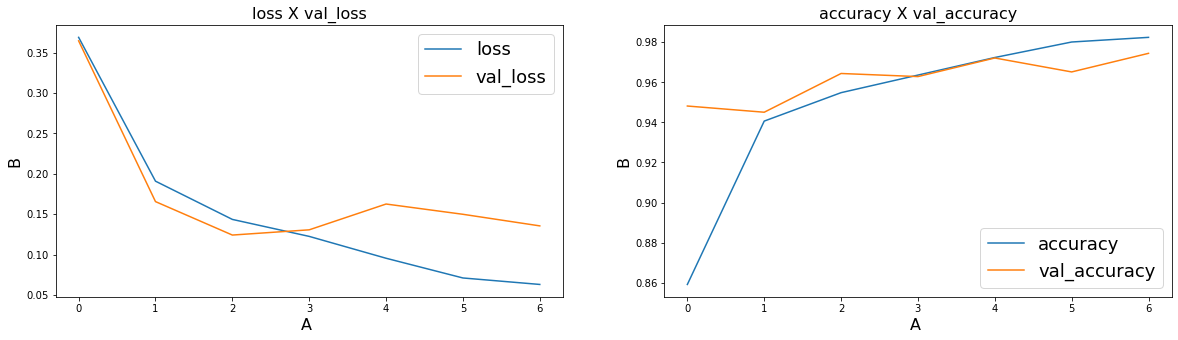

In [85]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [86]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_preds))

41/41 [==============================] - 2s 46ms/step


In [87]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [88]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [89]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [90]:
texts = df['message_clean']
target = df['target']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [91]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [92]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [93]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [94]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
414/414 [==============================] - 661s 2s/step - loss: 0.1635 - accuracy: 0.9466 - val_loss: 0.0891 - val_accuracy: 0.9652
Epoch 2/3
414/414 [==============================] - 629s 2s/step - loss: 0.0706 - accuracy: 0.9804 - val_loss: 0.0610 - val_accuracy: 0.9855
Epoch 3/3
414/414 [==============================] - 635s 2s/step - loss: 0.0373 - accuracy: 0.9896 - val_loss: 0.0516 - val_accuracy: 0.9845


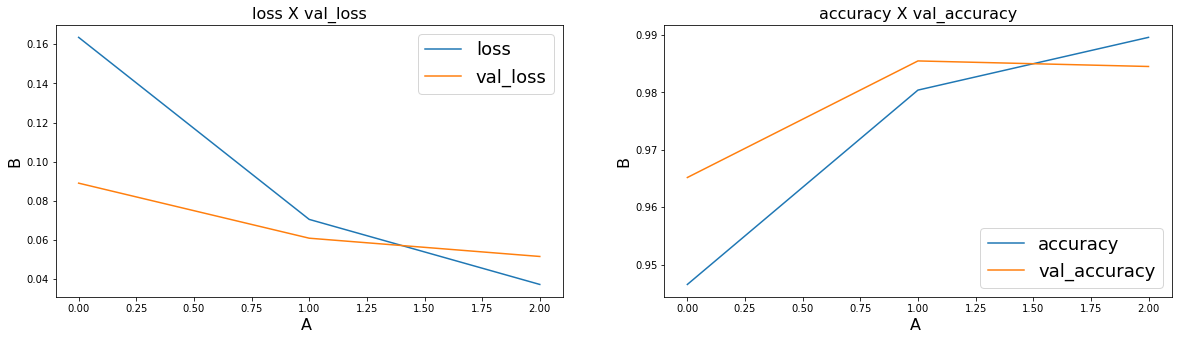

In [95]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])